In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

/home/jonat/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
m1 = 1
m2 = 1
m3 = 1
m4 = 1
m = np.array([m1, m2, m3, m4])
l1 = 1
l2 = 2
l3 = 1
l = np.array([l1, l2, l3])
g = 9.81

dt = 0.01
tf = 20
t = np.arange(0, tf, dt)

Q_0 = np.array([[2, 1], [1, 1], [-1, 1], [-2, 1]])
Q_dot_0 = np.array([[0, 0], [0, 0], [0, 0], [0, 0]])

n = 4
k = 3
M = np.diag([m1, m2, m3, m3]) # n x n
M_inv = np.linalg.inv(M) # n x n
G = np.array([[0, g] for _ in range(n)]) # n x 2
D_of_G = np.array([[ 1,  0,  0],
                             [-1,  1,  0],
                             [ 0, -1,  1],
                             [ 0,  0, -1]]) # n x k
Le_of_G = D_of_G.T@M_inv@D_of_G # k x k

# Edge Control
k1 = 20
k2 = 20

theta_d = lambda t: np.pi/4*np.cos(np.pi/4*t)
theta_d_dot = lambda t: -np.pi**2/16*np.sin(np.pi/4*t)
theta_d_ddot = lambda t: -np.pi**3/64*np.cos(np.pi/4*t)
Qed = lambda t: np.array([[l1*np.cos(theta_d(t)), l1*np.sin(theta_d(t))],
                             [l2*np.cos(theta_d(t)), -l2*np.sin(theta_d(t))],
                             [l3*np.cos(theta_d(t)), l3*np.sin(theta_d(t))]])
Qed_dot = lambda t: np.array([[-l1*np.sin(theta_d(t))*theta_d_dot(t), l1*np.cos(theta_d(t))*theta_d_dot(t)],
                                [-l2*np.sin(theta_d(t))*theta_d_dot(t), -l2*np.cos(theta_d(t))*theta_d_dot(t)],
                                [-l3*np.sin(theta_d(t))*theta_d_dot(t), l3*np.cos(theta_d(t))*theta_d_dot(t)]])
Qed_ddot = lambda t: np.array([[-l1*np.cos(theta_d(t))*theta_d_dot(t)**2 - l1*np.sin(theta_d(t))*theta_d_ddot(t), -l1*np.sin(theta_d(t))*theta_d_dot(t)**2 + l1*np.cos(theta_d(t))*theta_d_ddot(t)],
                                [-l2*np.cos(theta_d(t))*theta_d_dot(t)**2 - l2*np.sin(theta_d(t))*theta_d_ddot(t), -l2*np.sin(theta_d(t))*theta_d_dot(t)**2 + l2*np.cos(theta_d(t))*theta_d_ddot(t)],
                                [-l3*np.cos(theta_d(t))*theta_d_dot(t)**2 - l3*np.sin(theta_d(t))*theta_d_ddot(t), -l3*np.sin(theta_d(t))*theta_d_dot(t)**2 + l3*np.cos(theta_d(t))*theta_d_ddot(t)]])

def F_fun(Q, Q_dot, Qe, Qe_dot, t):
    temp = np.linalg.inv(np.multiply(Le_of_G, Qe@Qe.T))
    lambda_simplified = temp @ np.diagonal(Qe_dot@Qe_dot.T)
    Lambda_simplified = np.diag(lambda_simplified)
    S_temp = -k1*(Qe-Qed(t)) - k2*(Qe_dot-Qed_dot(t)) + Qed_ddot(t) #+ Le_of_G@Lambda_simplified@Qe

    # S = np.zeros((k, 2))
    # for j in range(k):
    #     re = Qe[j, :]
    #     l = np.linalg.norm(re)
    #     P = np.eye(2)-np.outer(re, re)/l**2
    #     S[j, :] = P@S_temp[j, :]
    
    S = S_temp - np.diag(np.diagonal(S_temp@Qe.T@np.diag([1/l[i]**2 for i in range(k)])))@Qe

    F = np.ones((n, 2))*np.nan
    f_leader = -k1*(Q[2, :] - np.array([-1, 0])) - k2*Q_dot[2, :]
    F[2, :] = f_leader

    while np.isnan(F).any():
        for i in np.where(np.isnan(F[:, 0]))[0]: # i is the node where we want to set a force
            for j in np.where(D_of_G[i, :] != 0)[0]: # j is the edge incident to the ith node
                head = np.where(D_of_G[:, j] == 1)[0][0]
                tail = np.where(D_of_G[:, j] == -1)[0][0]

                if head == i and ~np.isnan(F[tail, :]).any():
                    F[i, :] = m[i]*(S[j, :] + F[tail, :]/m[tail])
                elif tail == i and ~np.isnan(F[head, :]).any():
                    F[i, :] = m[i]*(-S[j, :] + F[head, :]/m[head])

    return F

def ODE(t, y):
    Q = y[:2*n].reshape((n, 2))
    Q_dot = y[2*n:].reshape((n, 2))
    Qe = D_of_G.T@Q
    Qe_dot = D_of_G.T@Q_dot

    temp = np.linalg.inv(np.multiply(Le_of_G, Qe@Qe.T))
    
    F_c = F_fun(Q, Q_dot, Qe, Qe_dot, t)
    F_g = M@G
    F = F_c + F_g
    
    lambda_full = temp @ np.diagonal(D_of_G.T@M_inv@F@Qe.T + Qe_dot@Qe_dot.T)
    Lambda_full = np.diag(lambda_full)
    Q_ddot = -G + M_inv@(F - D_of_G@Lambda_full@Qe)
    
    return np.concatenate((Q_dot.reshape(2*n), Q_ddot.reshape(2*n)))

sol = solve_ivp(ODE, (0, tf), np.concatenate((Q_0.reshape(2*n), Q_dot_0.reshape(2*n))), t_eval=t, method="DOP853", rtol=1e-10, atol=1e-10)
Q = sol.y[:2*n].reshape((n, 2, len(t)))
Q_dot = sol.y[2*n:].reshape((n, 2, len(t)))

Qe = np.empty((k, 2, len(t)))
for idx in range(len(t)):
    Qe[:, :, idx] = D_of_G.T@Q[:, :, idx]
Qe_dot = np.empty((k, 2, len(t)))
for idx in range(len(t)):
    Qe_dot[:, :, idx] = D_of_G.T@Q_dot[:, :, idx]

F_c = np.empty((n, 2, len(t)))
for idx in range(len(t)):
    F_c[:, :, idx] = F_fun(Q[:, :, idx], Q_dot[:, :, idx], Qe[:, :, idx], Qe_dot[:, :, idx], t[idx])

F_g = np.array([M@G for _ in range(len(t))]).transpose((1, 2, 0))

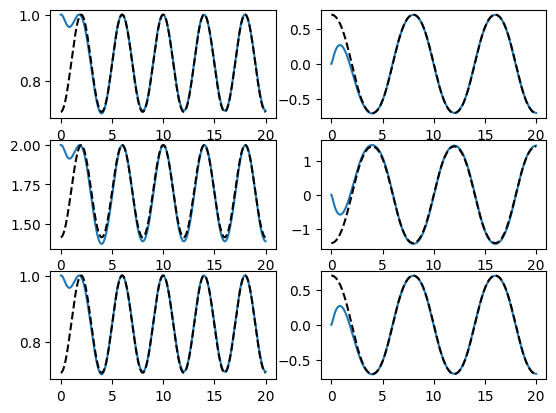

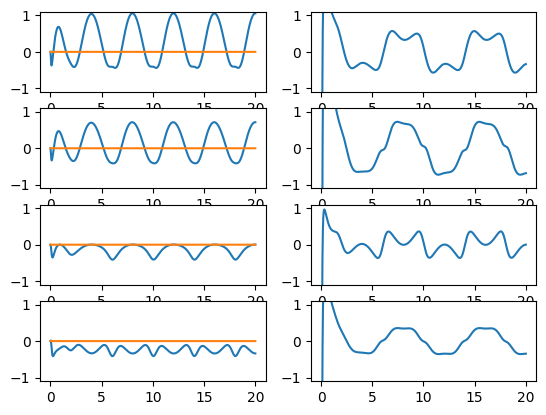

In [86]:
# # Nodes
# plt.figure()
# for i in range(n):
#     plt.subplot(n, 2, 2*i+1)
#     plt.plot(t, Q[i, 0], label='x'+str(i+1))
#     if i == 1:
#         plt.plot(t, r2d(t)[0], color='black', linestyle='--')
#     # plt.legend(loc='upper right')
#     plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

#     plt.subplot(n, 2, 2*i+2)
#     plt.plot(t, Q[i, 1], label='y'+str(i+1))
#     if i == 1:
#         plt.plot(t, r2d(t)[1], color='black', linestyle='--')
#     # plt.legend(loc='upper right')
#     plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

# plt.plot(t, np.zeros(len(t)), color='black', linestyle='--')

# Edges
plt.figure()
for i in range(k):
    plt.subplot(k, 2, 2*i+1)
    plt.plot(t, Qe[i, 0, :], label='xe'+str(i+1))
    plt.plot(t, [Qed(ti)[i, 0] for ti in t], color='black', linestyle='--')
    # plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

    plt.subplot(k, 2, 2*i+2)
    plt.plot(t, Qe[i, 1, :], label='ye'+str(i+1))
    plt.plot(t, [Qed(ti)[i, 1] for ti in t], color='black', linestyle='--')
    # plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

# # Theta
# plt.figure()
# plt.plot(t, ((q1x-q2x)*(q2x-q3x)+(q1y-q2y)*(q2y-q3y))/(l1*l2), label=r'$\cos\theta$')
# #plt.axhline(Qed_val[0, :].dot(Qed_val[1, :])/(l1*l2), color='black', linestyle='--', label=r'$\cos\theta_{d}$')
# plt.title(r'$\cos\theta$')
# plt.legend()
# #plt.gca().set_ylim(-1.01, -0.99)

# Forces
plt.figure()
for i in range(n):
    plt.subplot(n, 2, 2*i+1)
    plt.plot(t, F_c[i, 0], label='Fcx'+str(i+1))
    plt.plot(t, F_g[i, 0], label='Fgx'+str(i+1))
    # plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)
    plt.gca().set_ylim(-1.1, 1.1)

    plt.subplot(n, 2, 2*i+2)
    plt.plot(t, F_c[i, 1], label='Fcy'+str(i+1))
    plt.plot(t, F_g[i, 1], label='Fgy'+str(i+1))
    # plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)
    plt.gca().set_ylim(-1.1, 1.1)

In [87]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
ax.grid()

# Plot initial position
bars = []
for i in range(k):
    d_i = D_of_G[:, i]
    start_idx = np.where(d_i == 1)[0][0]
    end_idx = np.where(d_i == -1)[0][0]
    bar = ax.plot([Q_0[start_idx, 0], Q_0[end_idx, 0]], [Q_0[start_idx, 1], Q_0[end_idx, 1]], 'o-', color='purple', lw=2)[0]
    bars.append(bar)

F_c_arrows = []
F_n_arrows = []
F_g_arrows = []
for i in range(n):
    F_c_arrow = ax.arrow(Q[i, 0, 0], Q[i, 1, 0], F_c[i, 0, 0], F_c[i, 1, 0], head_width=0.1, head_length=0.1, fc='r', ec='r')
    F_g_arrow = ax.arrow(Q[i, 0, 0], Q[i, 1, 0], F_g[i, 0, 0]/10, F_g[i, 1, 0]/10, head_width=0.1, head_length=0.1, fc='b', ec='b')
    F_c_arrows.append(F_c_arrow)
    F_g_arrows.append(F_g_arrow)

# ax.text(0.05, 0.9, f'time: {t[0]:.1f} s', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=18)

fps = 30
def animate(i):
    idx = int(i/(fps*dt))
    for i in range(k):
        d_i = D_of_G[:, i]
        start_idx = np.where(d_i == 1)[0][0]
        end_idx = np.where(d_i == -1)[0][0]
        bars[i].set_data([Q[start_idx, 0, idx], Q[end_idx, 0, idx]], [Q[start_idx, 1, idx], Q[end_idx, 1, idx]])
    
    for i in range(n):
        F_c_arrows[i].set_data(x=Q[i, 0, idx], y=Q[i, 1, idx], dx=F_c[i, 0, idx], dy=F_c[i, 1, idx])
        F_g_arrows[i].set_data(x=Q[i, 0, idx], y=Q[i, 1, idx], dx=F_g[i, 0, idx]/10, dy=F_g[i, 1, idx]/10)

tf_sim = tf
ani = animation.FuncAnimation(fig, animate, frames=fps*tf_sim)
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save(f'leader-follower.mp4', writer=ffmpeg_writer)
plt.close(fig)